# Performance of PM classification

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf

from sklearn.utils import shuffle, resample
from tqdm import tqdm

from keras.utils import load_img, img_to_array, to_categorical
from keras.models import model_from_json, Model
from keras.optimizers import SGD, RMSprop, Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the CSV file
df = pd.read_excel(r'../../Datasets/PALM/All/Labels.xlsx', sheet_name='Sheet1')
dataset_path = r'../../Datasets/PALM/All/Images'

# Define constants
IMAGE_SIZE = (256, 256)  # Example size, adjust to your models
NUM_CLASSES = 2  # Grading levels 0-5

In [3]:
df['Label'].value_counts()

Label
1    637
0    563
Name: count, dtype: int64

## ResNet50

In [ ]:
from keras.applications.resnet import preprocess_input as resenet50_preprocess_input
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

from keras import backend as K
K.set_image_data_format('channels_last')

In [ ]:
with open(r'models_TL/ResNet50_pretrained.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights(r'models_TL/ResNet50_pretrained.weights.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Prepare dataset
X = []
y = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    image_path = row['imgName']
    label = row['Label']
    
    image_path = os.path.join(dataset_path, image_path)
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = vgg16_preprocess_input(x)
    X.append(x)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

y = to_categorical(y, num_classes=2)
X.shape, y.shape

In [ ]:
X.shape, y.shape

In [ ]:
predictions = model.predict(X)
y_pred = np.argmax(predictions, axis=1)  # Multiclass output
y_true = np.argmax(y, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
classification_rep = classification_report(y_true, y_pred, target_names=[f'Grade {i}' for i in range(2)])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("\nClassification Report:")
print(classification_rep)

## Features

In [4]:
# OD
with open(r'features_segmentation/OD.json', 'r') as json_file:
    model_json = json_file.read()
model_OD = model_from_json(model_json)
model_OD.load_weights(r'.features_segmentation/OD.weights.h5')
model_OD.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Atrophy
with open(r'features_segmentation/Atrophy.json', 'r') as json_file:
    model_json = json_file.read()
model_atrophy = model_from_json(model_json)
model_atrophy.load_weights('features_segmentation/Atrophy.weights.h5')
model_atrophy.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-12-14 12:05:03.666696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-14 12:05:03.666968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
with open(r'models_features/CNN_ODA.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights(r'models_features/CNN_ODA.weights.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Define function to preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img = img_to_array(img)
    img = img / 255.0
    return img


def generate_feature_maps(image_path):
    # Apply the specific preprocessing method for each model
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    
    mask1 = model_OD.predict(img, verbose=False)  # Predict mask
    mask1 = (mask1 > 0.1).astype(int)  # Convert to binary
    
    mask2 = model_atrophy.predict(img, verbose=False)  # Predict mask
    mask2 = (mask2 > 0.1).astype(int)  # Convert to binary

    # Combine masks into a single feature map
    combined = np.concatenate([mask1, mask2])  # Shape: (H, W, 4)
    combined = np.transpose(combined, (1, 2, 0, 3))
    combined = np.squeeze(combined)
    
    return combined


In [7]:
# Prepare dataset
X_features = []
y_labels = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    image_path = row['imgName']
    label = row['Label']
    
    image_path = os.path.join(dataset_path, image_path)
    
    combined_features = generate_feature_maps(image_path)
    X_features.append(combined_features)
    y_labels.append(label)

X_features = np.array(X_features)  # Shape: (num_samples, H, W, 4)
y_labels = tf.keras.utils.to_categorical(y_labels, NUM_CLASSES)

Processing rows:   0%|          | 0/1200 [00:00<?, ?it/s]2024-12-14 12:05:53.703244: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-12-14 12:05:53.776858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-14 12:05:54.137790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Processing rows: 100%|██████████| 1200/1200 [02:40<00:00,  7.48it/s]


In [8]:
X_features.shape, y_labels.shape

((1200, 256, 256, 2), (1200, 2))

2024-12-14 12:08:36.053096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 2s 32ms/step


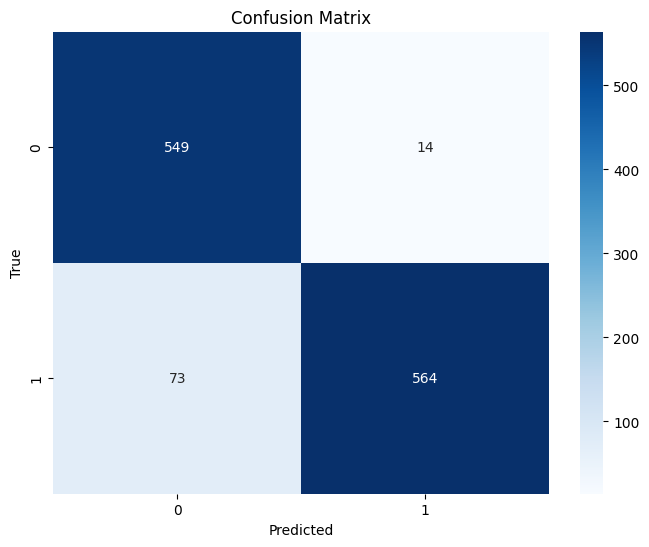

In [9]:
predictions = model.predict(X_features)
y_pred = np.argmax(predictions, axis=1)  # Multiclass output
y_true = np.argmax(y_labels, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
classification_rep = classification_report(y_true, y_pred, target_names=[f'Grade {i}' for i in range(2)])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.9275
Precision: 0.9320794762959089
Recall: 0.9275

Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.88      0.98      0.93       563
     Grade 1       0.98      0.89      0.93       637

    accuracy                           0.93      1200
   macro avg       0.93      0.93      0.93      1200
weighted avg       0.93      0.93      0.93      1200

